<a href="https://colab.research.google.com/github/erfan7emz/Transformer/blob/main/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 480/680 assignment 4

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for submission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

##Question1 - Adversarial Training (55 points)

In this assignment, you are supposed to train a model using limited data that, in addition to generalization, also possesses good robustness.


You can add any extra libraries that you need in this cell.

In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
!pip install umap
!pip install umap-learn
import umap
import umap.umap_ as umap
from torch.utils.data import DataLoader

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Q1.1 Load Data (5 points)

In this question, you are going to use CIFAR-10 dataset. First, load this dataset, then split 20% of the data for training and the rest for validation. Make sure to maintain class balance during the split.

In [ ]:
TRAIN_SIZE = 0.2
BATCH_SIZE = 64
cifar_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

#Split data and create the dataloader

def stratified_split(dataset, train_size):
    targets = [label for _, label in dataset]
    train_idx, val_idx = train_test_split(np.arange(len(targets)), test_size=1-train_size, stratify=targets)
    return train_idx, val_idx

train_idx, val_idx = stratified_split(cifar_trainset, TRAIN_SIZE)

train_dataset = Cifar10Dataset(cifar_trainset, train_idx, transforms=cifar_transforms)
val_dataset = Cifar10Dataset(cifar_trainset, val_idx, transforms=cifar_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")

Training set size: 10000 samples
Validation set size: 40000 samples


###Q1.2 Train Model (15 points)

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. You can use UMAP for dimensionality reduction. Note that for this task, you are not allowed to use the labels.

In [ ]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        #To do
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        #To do
        return self.model(x)

In [ ]:
def train(model,data_loader,criterion,optimizer,attack = False):

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            #To do

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_train_loss = running_loss / total
    accuracy = 100. * correct / total
    return average_train_loss, accuracy

In [ ]:
def test(model,data_loader,criterion,optimizer,attack=False):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            #To do

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_test_loss = running_loss / total
    accuracy = 100. * correct / total
    return average_test_loss, accuracy

In [ ]:
def plot_umap(features,y):
    #To do

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
    # transform the features to 2D
    embedding = reducer.fit_transform(features)

    plt.figure(figsize=(12, 8))

    if y is not None:
        plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=5)
        plt.colorbar()
    else:
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5)

    plt.title('UMAP projection of the dataset', fontsize=18)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 45.6MB/s]
   train: 100%|██████████| 157/157 [00:18<00:00,  8.38it/s]


Epoch 1, Train Loss: 1.3227696155548097, Train Acc: 55.36


   train: 100%|██████████| 157/157 [00:20<00:00,  7.69it/s]


Epoch 2, Train Loss: 0.8828185060501098, Train Acc: 70.66


   train: 100%|██████████| 157/157 [00:11<00:00, 13.50it/s]


Epoch 3, Train Loss: 0.7110524951934815, Train Acc: 76.16


   train: 100%|██████████| 157/157 [00:05<00:00, 26.46it/s]


Epoch 4, Train Loss: 0.5746161882400512, Train Acc: 81.21


   train: 100%|██████████| 157/157 [00:05<00:00, 26.97it/s]


Epoch 5, Train Loss: 0.4359294855117798, Train Acc: 85.28


   train: 100%|██████████| 157/157 [00:05<00:00, 27.17it/s]


Epoch 6, Train Loss: 0.33986372294425965, Train Acc: 88.79


   train: 100%|██████████| 157/157 [00:05<00:00, 26.38it/s]


Epoch 7, Train Loss: 0.30281302976608276, Train Acc: 90.12


   train: 100%|██████████| 157/157 [00:05<00:00, 27.06it/s]


Epoch 8, Train Loss: 0.24775849995613097, Train Acc: 91.65


   train: 100%|██████████| 157/157 [00:05<00:00, 26.20it/s]


Epoch 9, Train Loss: 0.18993948450088502, Train Acc: 93.7


   train: 100%|██████████| 157/157 [00:05<00:00, 27.92it/s]


Epoch 10, Train Loss: 0.18290098224878312, Train Acc: 93.81


   train: 100%|██████████| 157/157 [00:06<00:00, 26.04it/s]


Epoch 11, Train Loss: 0.1553928726553917, Train Acc: 94.99


   train: 100%|██████████| 157/157 [00:05<00:00, 28.40it/s]


Epoch 12, Train Loss: 0.1736670411467552, Train Acc: 94.08


   train: 100%|██████████| 157/157 [00:06<00:00, 26.06it/s]


Epoch 13, Train Loss: 0.12140187228322029, Train Acc: 95.85


   train: 100%|██████████| 157/157 [00:05<00:00, 28.46it/s]


Epoch 14, Train Loss: 0.10170824728310109, Train Acc: 96.88


   train: 100%|██████████| 157/157 [00:06<00:00, 25.82it/s]


Epoch 15, Train Loss: 0.09622700354456902, Train Acc: 96.67


   train: 100%|██████████| 157/157 [00:06<00:00, 25.13it/s]


Epoch 16, Train Loss: 0.10835555552840233, Train Acc: 96.48


   train: 100%|██████████| 157/157 [00:05<00:00, 26.18it/s]


Epoch 17, Train Loss: 0.09613454131782055, Train Acc: 96.83


   train: 100%|██████████| 157/157 [00:06<00:00, 25.36it/s]


Epoch 18, Train Loss: 0.07461862076222897, Train Acc: 97.42


   train: 100%|██████████| 157/157 [00:07<00:00, 20.43it/s]


Epoch 19, Train Loss: 0.05896176628917456, Train Acc: 98.06


   train: 100%|██████████| 157/157 [00:05<00:00, 27.42it/s]


Epoch 20, Train Loss: 0.08743786411285401, Train Acc: 97.33


   train: 100%|██████████| 157/157 [00:05<00:00, 26.63it/s]


Epoch 21, Train Loss: 0.08716591278314591, Train Acc: 97.05


   train: 100%|██████████| 157/157 [00:05<00:00, 27.93it/s]


Epoch 22, Train Loss: 0.08251053687632084, Train Acc: 97.23


   train: 100%|██████████| 157/157 [00:06<00:00, 25.88it/s]


Epoch 23, Train Loss: 0.05624463913589716, Train Acc: 98.24


   train: 100%|██████████| 157/157 [00:05<00:00, 27.39it/s]


Epoch 24, Train Loss: 0.06251509063690901, Train Acc: 97.9


   train: 100%|██████████| 157/157 [00:06<00:00, 25.60it/s]


Epoch 25, Train Loss: 0.0677135026872158, Train Acc: 97.92


   train: 100%|██████████| 157/157 [00:05<00:00, 28.22it/s]


Epoch 26, Train Loss: 0.05009022760242224, Train Acc: 98.56


   train: 100%|██████████| 157/157 [00:06<00:00, 25.86it/s]


Epoch 27, Train Loss: 0.1105723856985569, Train Acc: 96.87


   train: 100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch 28, Train Loss: 0.1181763824224472, Train Acc: 96.51


   train: 100%|██████████| 157/157 [00:06<00:00, 25.63it/s]


Epoch 29, Train Loss: 0.052014112704992295, Train Acc: 98.41


   train: 100%|██████████| 157/157 [00:05<00:00, 27.60it/s]


Epoch 30, Train Loss: 0.07982373814433813, Train Acc: 97.55


   train: 100%|██████████| 157/157 [00:06<00:00, 25.65it/s]


Epoch 31, Train Loss: 0.029852753430977465, Train Acc: 99.02


   train: 100%|██████████| 157/157 [00:05<00:00, 28.15it/s]


Epoch 32, Train Loss: 0.03210543788783252, Train Acc: 98.92


   train: 100%|██████████| 157/157 [00:06<00:00, 25.67it/s]


Epoch 33, Train Loss: 0.0518704932231456, Train Acc: 98.46


   train: 100%|██████████| 157/157 [00:05<00:00, 28.26it/s]


Epoch 34, Train Loss: 0.06046424214616418, Train Acc: 98.02


   train: 100%|██████████| 157/157 [00:06<00:00, 25.97it/s]


Epoch 35, Train Loss: 0.06581956740617752, Train Acc: 98.01


   train: 100%|██████████| 157/157 [00:06<00:00, 25.76it/s]


Epoch 36, Train Loss: 0.05470132180340588, Train Acc: 98.39


   train: 100%|██████████| 157/157 [00:06<00:00, 26.09it/s]


Epoch 37, Train Loss: 0.026843148930883035, Train Acc: 99.2


   train: 100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


Epoch 38, Train Loss: 0.03433693258315325, Train Acc: 98.96


   train: 100%|██████████| 157/157 [00:06<00:00, 25.85it/s]


Epoch 39, Train Loss: 0.018447270072065293, Train Acc: 99.39


   train: 100%|██████████| 157/157 [00:05<00:00, 28.00it/s]


Epoch 40, Train Loss: 0.03297402258105576, Train Acc: 98.89


   train: 100%|██████████| 157/157 [00:06<00:00, 25.68it/s]


Epoch 41, Train Loss: 0.08798059362471104, Train Acc: 97.47


   train: 100%|██████████| 157/157 [00:05<00:00, 28.21it/s]


Epoch 42, Train Loss: 0.03000988814458251, Train Acc: 99.11


   train: 100%|██████████| 157/157 [00:07<00:00, 21.76it/s]


Epoch 43, Train Loss: 0.040861279522627594, Train Acc: 98.7


   train: 100%|██████████| 157/157 [00:05<00:00, 27.97it/s]


Epoch 44, Train Loss: 0.04161629473268986, Train Acc: 98.65


   train: 100%|██████████| 157/157 [00:06<00:00, 25.86it/s]


Epoch 45, Train Loss: 0.025012430394254624, Train Acc: 99.21


   train: 100%|██████████| 157/157 [00:05<00:00, 28.27it/s]


Epoch 46, Train Loss: 0.0486838754946366, Train Acc: 98.49


   train: 100%|██████████| 157/157 [00:06<00:00, 25.21it/s]


Epoch 47, Train Loss: 0.018489193838695066, Train Acc: 99.44


   train: 100%|██████████| 157/157 [00:05<00:00, 28.15it/s]


Epoch 48, Train Loss: 0.02744913133662194, Train Acc: 99.09


   train: 100%|██████████| 157/157 [00:06<00:00, 26.11it/s]


Epoch 49, Train Loss: 0.025010164957493544, Train Acc: 99.14


   train: 100%|██████████| 157/157 [00:05<00:00, 27.35it/s]


Epoch 50, Train Loss: 0.07638219131156802, Train Acc: 97.67


   train: 100%|██████████| 157/157 [00:05<00:00, 27.09it/s]


Epoch 51, Train Loss: 0.03321294873543083, Train Acc: 98.9


   train: 100%|██████████| 157/157 [00:05<00:00, 27.45it/s]


Epoch 52, Train Loss: 0.04064070418998599, Train Acc: 98.75


   train: 100%|██████████| 157/157 [00:05<00:00, 27.47it/s]


Epoch 53, Train Loss: 0.0482300689868629, Train Acc: 98.66


   train: 100%|██████████| 157/157 [00:05<00:00, 26.36it/s]


Epoch 54, Train Loss: 0.04136467406414449, Train Acc: 98.8


   train: 100%|██████████| 157/157 [00:05<00:00, 27.67it/s]


Epoch 55, Train Loss: 0.03716989112682641, Train Acc: 98.87


   train: 100%|██████████| 157/157 [00:05<00:00, 26.17it/s]


Epoch 56, Train Loss: 0.017483751041954383, Train Acc: 99.48


   train: 100%|██████████| 157/157 [00:05<00:00, 28.18it/s]


Epoch 57, Train Loss: 0.017217408478818835, Train Acc: 99.48


   train: 100%|██████████| 157/157 [00:06<00:00, 26.09it/s]


Epoch 58, Train Loss: 0.017445145898498594, Train Acc: 99.46


   train: 100%|██████████| 157/157 [00:05<00:00, 28.31it/s]


Epoch 59, Train Loss: 0.017271244407305493, Train Acc: 99.45


   train: 100%|██████████| 157/157 [00:05<00:00, 26.44it/s]


Epoch 60, Train Loss: 0.03317794299069792, Train Acc: 98.89


   train: 100%|██████████| 157/157 [00:05<00:00, 28.40it/s]


Epoch 61, Train Loss: 0.057160663026198745, Train Acc: 98.15


   train: 100%|██████████| 157/157 [00:06<00:00, 25.45it/s]


Epoch 62, Train Loss: 0.05380349379181862, Train Acc: 98.41


   train: 100%|██████████| 157/157 [00:05<00:00, 26.97it/s]


Epoch 63, Train Loss: 0.02242856556340121, Train Acc: 99.28


   train: 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


Epoch 64, Train Loss: 0.011394213314028456, Train Acc: 99.67


   train: 100%|██████████| 157/157 [00:05<00:00, 27.62it/s]


Epoch 65, Train Loss: 0.013055724284704775, Train Acc: 99.64


   train: 100%|██████████| 157/157 [00:06<00:00, 25.34it/s]


Epoch 66, Train Loss: 0.013043742999667303, Train Acc: 99.6


   train: 100%|██████████| 157/157 [00:05<00:00, 27.87it/s]


Epoch 67, Train Loss: 0.021183673742087558, Train Acc: 99.26


   train: 100%|██████████| 157/157 [00:06<00:00, 25.29it/s]


Epoch 68, Train Loss: 0.030888153883069754, Train Acc: 98.94


   train: 100%|██████████| 157/157 [00:05<00:00, 27.43it/s]


Epoch 69, Train Loss: 0.04222656293399632, Train Acc: 98.73


   train: 100%|██████████| 157/157 [00:06<00:00, 24.94it/s]


Epoch 70, Train Loss: 0.02034736892115325, Train Acc: 99.39


   test: 100%|██████████| 157/157 [00:03<00:00, 43.33it/s]


Validation Loss: 1.523212619304657, Validation Acc: 73.0
Test Loss: 1.568532956123352, Test Acc: 72.15


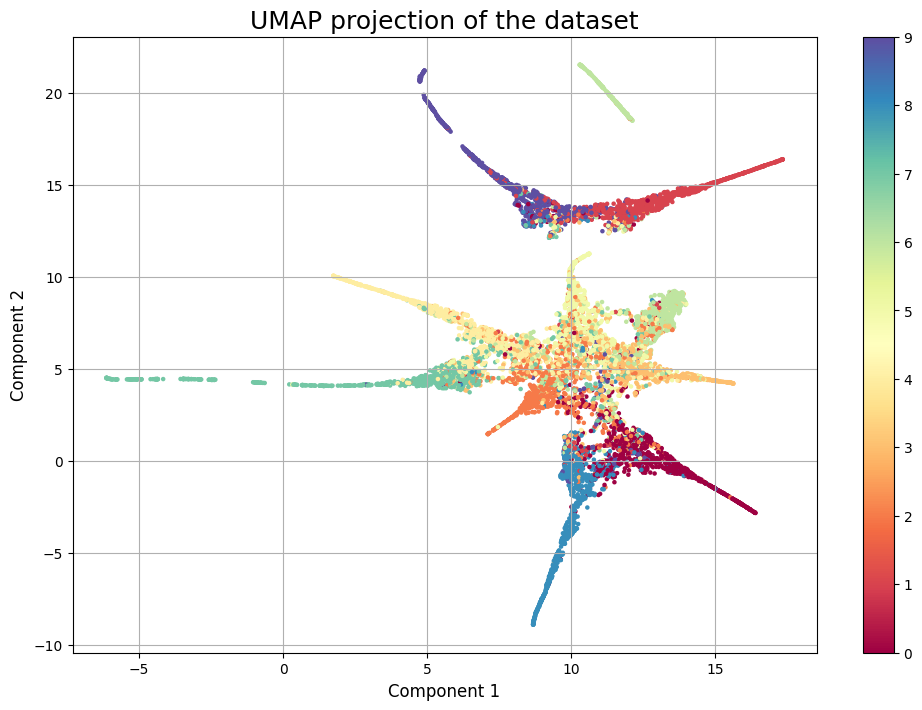

In [ ]:
model = Resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 70
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Acc: {train_acc}')

# Evaluating the model
val_loss, val_acc = test(model, val_loader, criterion, optimizer)
test_loss, test_acc = test(model, test_loader, criterion, optimizer)
print(f'Validation Loss: {val_loss}, Validation Acc: {val_acc}')
print(f'Test Loss: {test_loss}, Test Acc: {test_acc}')

def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

model.fc = nn.Identity()
features, y_test = extract_features(model, test_loader)
plot_umap(features, y_test)

###Q1.3 Adversarial Test (15 points)


In this section, you are required to change the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Your changes should include data augmentations such as adding Gaussian noise, color jitter, etc. Additionally, you should apply an adversarial attack such as fast gradient method on the network. You can use the cleverhans library for this purpose.

In [ ]:
augmentation = transforms.Compose([
    #To do
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
def generate_fgm_examples(model,data_loader,criterion, epsilon=0.03):
    model.eval()
    examples = []
    labels = []

    with tqdm(data_loader) as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            #To do

            inputs.requires_grad = True

            outputs = model(inputs)
            model.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()

            adv_examples = inputs + epsilon * inputs.grad.sign()
            adv_examples = torch.clamp(adv_examples, 0, 1)

            examples.append(adv_examples.detach().cpu().numpy())
            labels.append(targets.cpu().numpy())

    examples = np.concatenate(examples, axis=0)
    labels = np.concatenate(labels, axis=0)

    return examples,labels

100%|██████████| 157/157 [00:22<00:00,  7.01it/s]


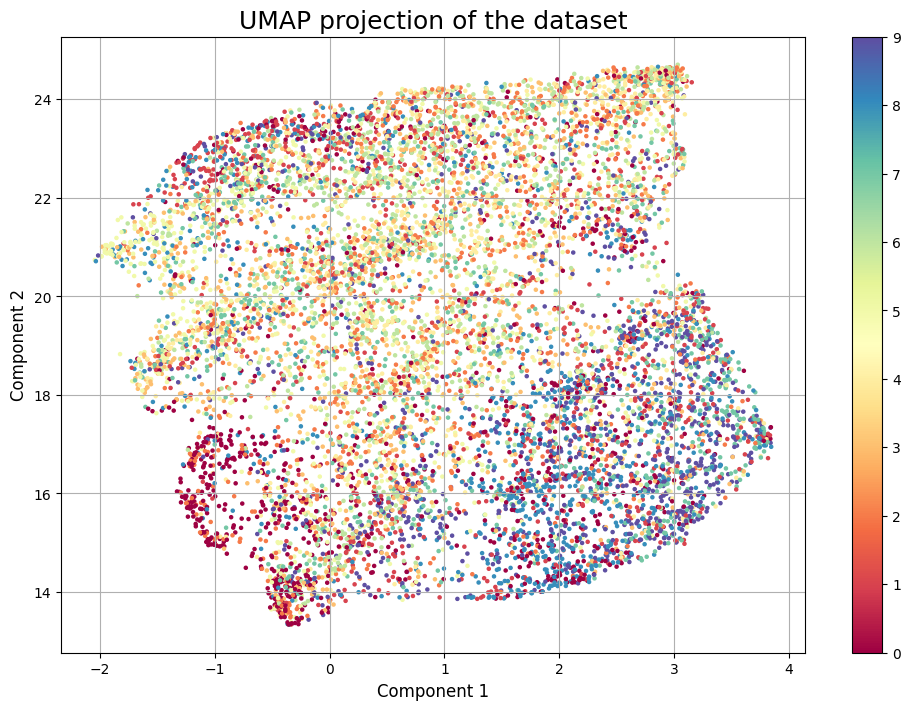

In [ ]:
cifar_testset.transform = augmentation
adv_test_loader = DataLoader(cifar_testset, batch_size=64, shuffle=False)

model.to(device)
criterion = nn.CrossEntropyLoss()

advx_test, advy_test = generate_fgm_examples(model, adv_test_loader, criterion)

features = advx_test.reshape(advx_test.shape[0], -1)
plot_umap(features,advy_test)

##Q1.4 Adversarial Train (20 points)


In this section, you should repeat the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [ ]:
#Train resnet18 using the adversarial examples
def generate_fgm_examples_for_training(model, data_loader, criterion, epsilon=0.03):
    model.eval()
    examples = []
    labels = []

    for inputs, targets in tqdm(data_loader, desc="Generating FGM Examples"):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          adv_examples = inputs + epsilon * inputs.grad.sign()
          adv_examples = torch.clamp(adv_examples, 0, 1)

        examples.append(adv_examples.detach())
        labels.append(targets)

    adv_dataset = torch.utils.data.TensorDataset(torch.cat(examples), torch.cat(labels))
    adv_data_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=data_loader.batch_size, shuffle=True)

    return adv_data_loader

model = Resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

adv_train_dataset = Cifar10Dataset(cifar_trainset, train_idx, transforms=augmentation)
adv_train_loader = DataLoader(adv_train_dataset, batch_size=64, shuffle=True)

adv_train_loader = generate_fgm_examples_for_training(model, adv_train_loader, criterion)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, adv_train_loader, criterion, optimizer)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Acc: {train_acc}')

# Convert adversarial examples and labels back into tensors
advx_test_tensor = torch.tensor(advx_test).float()
advy_test_tensor = torch.tensor(advy_test).long()

# Create a TensorDataset and DataLoader
adv_test_dataset = torch.utils.data.TensorDataset(advx_test_tensor, advy_test_tensor)
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=64, shuffle=False)


adv_features, advy_test = extract_features(model, adv_test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
   train: 100%|██████████| 157/157 [00:03<00:00, 47.56it/s]


Epoch 1, Train Loss: 1.677589295578003, Train Acc: 40.93


   train: 100%|██████████| 157/157 [00:03<00:00, 47.53it/s]


Epoch 2, Train Loss: 1.3205537549972535, Train Acc: 55.36


   train: 100%|██████████| 157/157 [00:03<00:00, 48.96it/s]


Epoch 3, Train Loss: 1.1066984127998352, Train Acc: 62.41


   train: 100%|██████████| 157/157 [00:03<00:00, 49.55it/s]


Epoch 4, Train Loss: 0.9263070722579956, Train Acc: 68.85


   train: 100%|██████████| 157/157 [00:03<00:00, 46.33it/s]


Epoch 5, Train Loss: 0.7799813552856445, Train Acc: 73.89


   train: 100%|██████████| 157/157 [00:03<00:00, 48.59it/s]


Epoch 6, Train Loss: 0.6190109296798706, Train Acc: 79.5


   train: 100%|██████████| 157/157 [00:03<00:00, 49.34it/s]


Epoch 7, Train Loss: 0.5061400703430176, Train Acc: 82.8


   train: 100%|██████████| 157/157 [00:03<00:00, 49.60it/s]


Epoch 8, Train Loss: 0.4545938237190247, Train Acc: 84.64


   train: 100%|██████████| 157/157 [00:03<00:00, 46.32it/s]


Epoch 9, Train Loss: 0.3977794767856598, Train Acc: 86.49


   train: 100%|██████████| 157/157 [00:03<00:00, 48.71it/s]


Epoch 10, Train Loss: 0.2796058055639267, Train Acc: 90.8


   train: 100%|██████████| 157/157 [00:03<00:00, 48.93it/s]


Epoch 11, Train Loss: 0.2550137026786804, Train Acc: 91.25


   train: 100%|██████████| 157/157 [00:03<00:00, 49.08it/s]


Epoch 12, Train Loss: 0.20380357623100281, Train Acc: 93.28


   train: 100%|██████████| 157/157 [00:03<00:00, 46.85it/s]


Epoch 13, Train Loss: 0.23112435977458953, Train Acc: 92.3


   train: 100%|██████████| 157/157 [00:03<00:00, 49.29it/s]


Epoch 14, Train Loss: 0.184884934130311, Train Acc: 93.72


   train: 100%|██████████| 157/157 [00:03<00:00, 49.13it/s]


Epoch 15, Train Loss: 0.15353928253650664, Train Acc: 94.97


   train: 100%|██████████| 157/157 [00:03<00:00, 47.24it/s]


Epoch 16, Train Loss: 0.1671554886341095, Train Acc: 94.65


   train: 100%|██████████| 157/157 [00:03<00:00, 48.08it/s]


Epoch 17, Train Loss: 0.12354569095373154, Train Acc: 96.05


   train: 100%|██████████| 157/157 [00:03<00:00, 49.57it/s]


Epoch 18, Train Loss: 0.32702733030319214, Train Acc: 89.24


   train: 100%|██████████| 157/157 [00:03<00:00, 49.63it/s]


Epoch 19, Train Loss: 0.13114480053335428, Train Acc: 95.61


   train: 100%|██████████| 157/157 [00:03<00:00, 46.86it/s]


Epoch 20, Train Loss: 0.09826203074753284, Train Acc: 96.74


   train: 100%|██████████| 157/157 [00:03<00:00, 49.51it/s]


Epoch 21, Train Loss: 0.10282045387029648, Train Acc: 96.61


   train: 100%|██████████| 157/157 [00:03<00:00, 49.46it/s]


Epoch 22, Train Loss: 0.11343913125693798, Train Acc: 96.42


   train: 100%|██████████| 157/157 [00:03<00:00, 49.45it/s]


Epoch 23, Train Loss: 0.08809958049356938, Train Acc: 97.05


   train: 100%|██████████| 157/157 [00:03<00:00, 46.26it/s]


Epoch 24, Train Loss: 0.102571525233984, Train Acc: 96.59


   train: 100%|██████████| 157/157 [00:03<00:00, 49.30it/s]


Epoch 25, Train Loss: 0.08852353748381138, Train Acc: 97.06


   train: 100%|██████████| 157/157 [00:03<00:00, 49.22it/s]


Epoch 26, Train Loss: 0.13059985690116882, Train Acc: 95.67


   train: 100%|██████████| 157/157 [00:03<00:00, 48.50it/s]


Epoch 27, Train Loss: 0.07370042260587216, Train Acc: 97.51


   train: 100%|██████████| 157/157 [00:03<00:00, 47.11it/s]


Epoch 28, Train Loss: 0.22224694406986237, Train Acc: 93.07


   train: 100%|██████████| 157/157 [00:03<00:00, 49.58it/s]


Epoch 29, Train Loss: 0.08700700691640377, Train Acc: 97.11


   train: 100%|██████████| 157/157 [00:03<00:00, 49.53it/s]


Epoch 30, Train Loss: 0.08778583432678133, Train Acc: 97.08


   train: 100%|██████████| 157/157 [00:03<00:00, 46.71it/s]


Epoch 31, Train Loss: 0.05959800268113613, Train Acc: 97.95


   train: 100%|██████████| 157/157 [00:03<00:00, 48.28it/s]


Epoch 32, Train Loss: 0.06598452593237161, Train Acc: 97.83


   train: 100%|██████████| 157/157 [00:03<00:00, 49.60it/s]


Epoch 33, Train Loss: 0.0828583038598299, Train Acc: 97.26


   train: 100%|██████████| 157/157 [00:03<00:00, 49.50it/s]


Epoch 34, Train Loss: 0.053956809078902004, Train Acc: 98.07


   train: 100%|██████████| 157/157 [00:03<00:00, 46.49it/s]


Epoch 35, Train Loss: 0.05076689923256636, Train Acc: 98.27


   train: 100%|██████████| 157/157 [00:03<00:00, 49.05it/s]


Epoch 36, Train Loss: 0.05762453573271632, Train Acc: 98.14


   train: 100%|██████████| 157/157 [00:03<00:00, 49.60it/s]


Epoch 37, Train Loss: 0.07477822390198707, Train Acc: 97.63


   train: 100%|██████████| 157/157 [00:03<00:00, 48.65it/s]


Epoch 38, Train Loss: 0.05045437448769808, Train Acc: 98.3


   train: 100%|██████████| 157/157 [00:03<00:00, 47.15it/s]


Epoch 39, Train Loss: 0.08822488011419773, Train Acc: 97.45


   train: 100%|██████████| 157/157 [00:03<00:00, 49.58it/s]


Epoch 40, Train Loss: 0.06274668840169907, Train Acc: 97.82


   train: 100%|██████████| 157/157 [00:03<00:00, 49.19it/s]


Epoch 41, Train Loss: 0.049781006245315076, Train Acc: 98.21


   train: 100%|██████████| 157/157 [00:03<00:00, 47.32it/s]


Epoch 42, Train Loss: 0.1210321650326252, Train Acc: 96.22


   train: 100%|██████████| 157/157 [00:03<00:00, 47.88it/s]


Epoch 43, Train Loss: 0.053964928148500624, Train Acc: 98.14


   train: 100%|██████████| 157/157 [00:03<00:00, 49.55it/s]


Epoch 44, Train Loss: 0.03837772381016984, Train Acc: 98.63


   train: 100%|██████████| 157/157 [00:03<00:00, 49.45it/s]


Epoch 45, Train Loss: 0.03909035728909075, Train Acc: 98.69


   train: 100%|██████████| 157/157 [00:03<00:00, 46.21it/s]


Epoch 46, Train Loss: 0.041359279693011196, Train Acc: 98.71


   train: 100%|██████████| 157/157 [00:03<00:00, 49.39it/s]


Epoch 47, Train Loss: 0.10688952802121639, Train Acc: 96.5


   train: 100%|██████████| 157/157 [00:03<00:00, 49.26it/s]


Epoch 48, Train Loss: 0.05103261146172881, Train Acc: 98.31


   train: 100%|██████████| 157/157 [00:03<00:00, 49.32it/s]


Epoch 49, Train Loss: 0.093652625580132, Train Acc: 97.31


   train: 100%|██████████| 157/157 [00:03<00:00, 46.64it/s]


Epoch 50, Train Loss: 0.04304145559221506, Train Acc: 98.67


   train: 100%|██████████| 157/157 [00:03<00:00, 49.56it/s]


Epoch 51, Train Loss: 0.08770224930047989, Train Acc: 97.29


   train: 100%|██████████| 157/157 [00:03<00:00, 49.53it/s]


Epoch 52, Train Loss: 0.05611560745686293, Train Acc: 98.22


   train: 100%|██████████| 157/157 [00:03<00:00, 48.53it/s]


Epoch 53, Train Loss: 0.03693733834438026, Train Acc: 98.77


   train: 100%|██████████| 157/157 [00:03<00:00, 46.89it/s]


Epoch 54, Train Loss: 0.04900608347281814, Train Acc: 98.47


   train: 100%|██████████| 157/157 [00:03<00:00, 49.27it/s]


Epoch 55, Train Loss: 0.03359583417102695, Train Acc: 98.87


   train: 100%|██████████| 157/157 [00:03<00:00, 49.09it/s]


Epoch 56, Train Loss: 0.03546565960720181, Train Acc: 98.86


   train: 100%|██████████| 157/157 [00:03<00:00, 46.58it/s]


Epoch 57, Train Loss: 0.08565637428238988, Train Acc: 97.25


   train: 100%|██████████| 157/157 [00:03<00:00, 48.42it/s]


Epoch 58, Train Loss: 0.08340093008130789, Train Acc: 97.48


   train: 100%|██████████| 157/157 [00:03<00:00, 49.60it/s]


Epoch 59, Train Loss: 0.061477751726657155, Train Acc: 98.15


   train: 100%|██████████| 157/157 [00:03<00:00, 49.33it/s]


Epoch 60, Train Loss: 0.024369589095935226, Train Acc: 99.22


   train: 100%|██████████| 157/157 [00:03<00:00, 46.10it/s]


Epoch 61, Train Loss: 0.015606008944986389, Train Acc: 99.45


   train: 100%|██████████| 157/157 [00:03<00:00, 49.46it/s]


Epoch 62, Train Loss: 0.027977668914943934, Train Acc: 98.95


   train: 100%|██████████| 157/157 [00:03<00:00, 49.48it/s]


Epoch 63, Train Loss: 0.059459029370453206, Train Acc: 98.14


   train: 100%|██████████| 157/157 [00:03<00:00, 48.78it/s]


Epoch 64, Train Loss: 0.034553165992395954, Train Acc: 98.77


   train: 100%|██████████| 157/157 [00:03<00:00, 46.90it/s]


Epoch 65, Train Loss: 0.027500473369751127, Train Acc: 99.1


   train: 100%|██████████| 157/157 [00:03<00:00, 49.47it/s]


Epoch 66, Train Loss: 0.036891026006639, Train Acc: 98.91


   train: 100%|██████████| 157/157 [00:03<00:00, 49.17it/s]


Epoch 67, Train Loss: 0.035921747727692126, Train Acc: 98.88


   train: 100%|██████████| 157/157 [00:03<00:00, 47.32it/s]


Epoch 68, Train Loss: 0.03825116424616426, Train Acc: 98.7


   train: 100%|██████████| 157/157 [00:03<00:00, 48.43it/s]


Epoch 69, Train Loss: 0.0762452534765005, Train Acc: 97.61


   train: 100%|██████████| 157/157 [00:03<00:00, 49.47it/s]


Epoch 70, Train Loss: 0.06171327286884189, Train Acc: 98.1


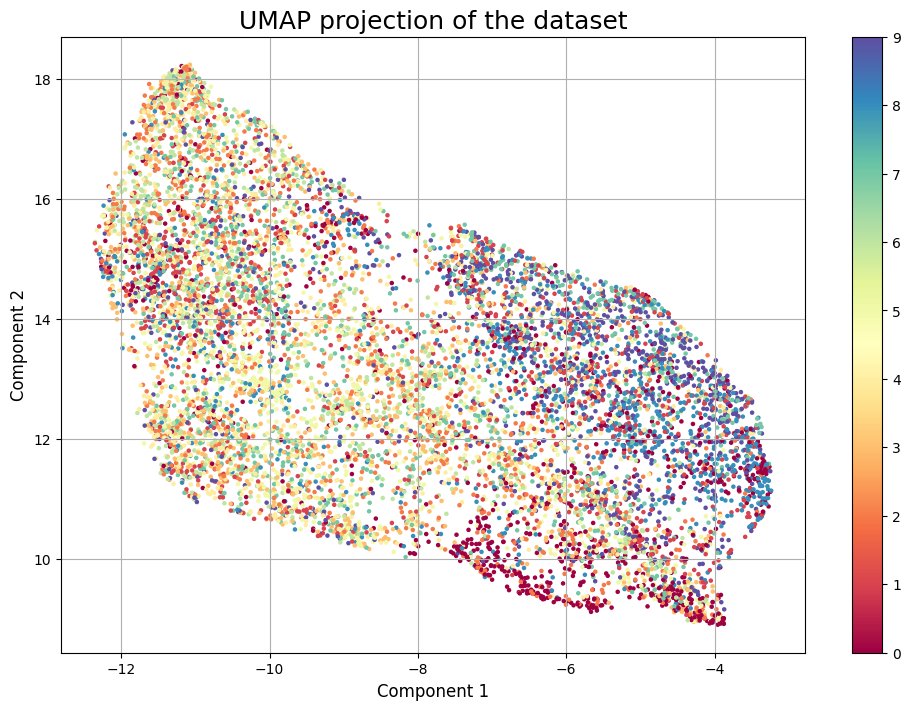

In [ ]:
plot_umap(features,y_test)

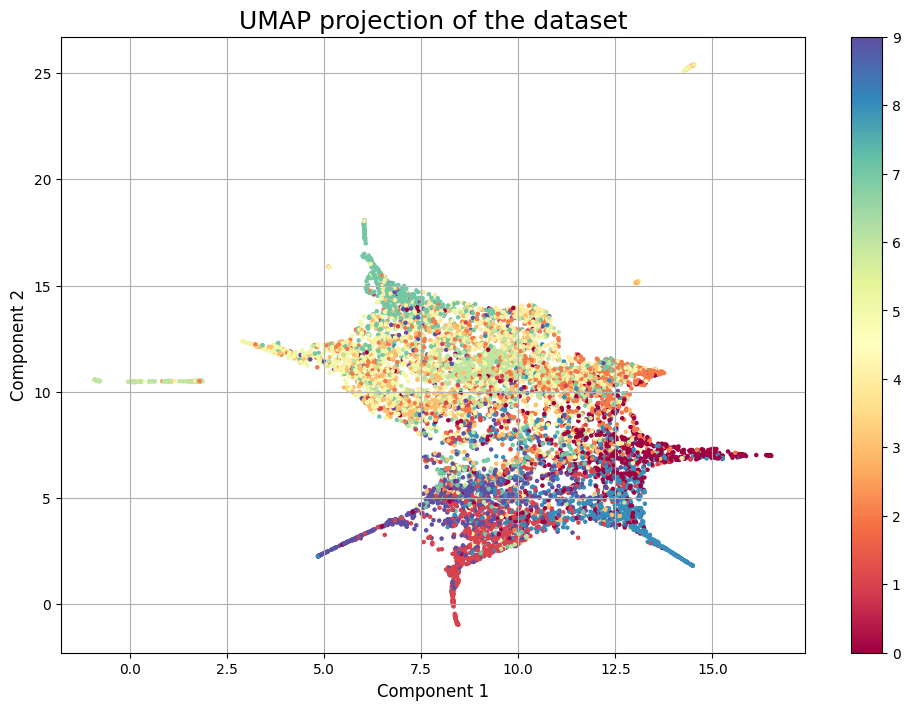

In [ ]:
plot_umap(adv_features,advy_test)

##Question2 - Diffusion Model (45 points)

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  



You can add any extra libraries that you need in this cell.

In [ ]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
!pip install diffusers
from diffusers import UNet2DModel, DDPMPipeline, DDIMPipeline, PNDMPipeline, DDPMScheduler

###Q2.1 Load Data (5 points)

In this question, you are going to use one arbitrary class of CIFAR-10 dataset. First, load this dataset, then choose any class you want and use that for the rest of this question.

In [ ]:
#Load the data and choose one class, then create the data loader.

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
class_index = 1

images, labels = zip(*[(img, label) for img, label in zip(train_dataset.data, train_dataset.targets) if label == class_index])

images = np.array(images)
label = np.array(labels)

Files already downloaded and verified


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        #To do
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #To do
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = CustomDataset(images=images, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

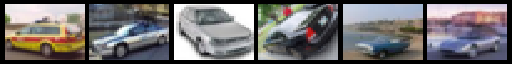

In [ ]:
x_test = next(iter(dataloader))[:6]
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)

###Q2.2 Forward pass (10 points)

In this section, you are going to implement the forward pass of your diffusion model. You can use diffusers library for this task. Then use show_images function to plot your target image at different times of the forward pass. (Simply use the default hypermeters mentioned in the DDPM paper or the default values of the diffuser library. Visualising images every 100 steps is enough)

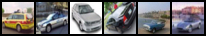

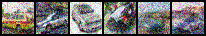

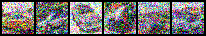

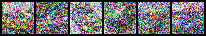

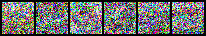

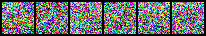

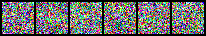

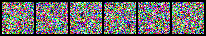

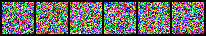

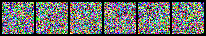

In [ ]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
for timestep in range(0, 1000, 100):
    noise = torch.randn(x_test.shape)
    timesteps = torch.LongTensor([timestep])
    noisy_image = scheduler.add_noise(x_test, noise, timesteps)
    img = show_images(noisy_image)
    display(img)

###Q2.3 Denoising (15 points)

In this section, you will implement the denoising part of your diffusion model. First, create a U-net and train it on your CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples. (In the DDPM paper Sec 3.3, they also trained a reverse process decoder. You are not required to implement it in this assignment. Visualizing the outputs of the diffusion network is sufficient.)

In [ ]:
model = UNet2DModel(
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [ ]:
def train(model,data_loader,criterion,optimizer):

    total_loss = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, inputs in enumerate(train_tqdm):
            model.train()
            inputs = inputs.to(device)
            #To do

            noise = torch.randn_like(inputs)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (inputs.size(0),), device=device)
            noisy_inputs = scheduler.add_noise(inputs, noise, timesteps)
            denoised_outputs = model(noisy_inputs, timesteps).sample

            loss = criterion(denoised_outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_tqdm.set_description(f"Training - Loss: {loss.item():.4f}")

    average_train_loss = total_loss / len(train_tqdm)
    return average_train_loss

Epoch 1/70


   train:   0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Training - Loss: 0.1777: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Average Train Loss: 0.2139

Epoch 2/70


Training - Loss: 0.1803: 100%|██████████| 79/79 [00:10<00:00,  7.53it/s]


Average Train Loss: 0.1895

Epoch 3/70


Training - Loss: 0.1714: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Average Train Loss: 0.1683

Epoch 4/70


Training - Loss: 0.1117: 100%|██████████| 79/79 [00:10<00:00,  7.39it/s]


Average Train Loss: 0.1553

Epoch 5/70


Training - Loss: 0.1275: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


Average Train Loss: 0.1487

Epoch 6/70


Training - Loss: 0.1551: 100%|██████████| 79/79 [00:10<00:00,  7.47it/s]


Average Train Loss: 0.1461

Epoch 7/70


Training - Loss: 0.1005: 100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


Average Train Loss: 0.1448

Epoch 8/70


Training - Loss: 0.1009: 100%|██████████| 79/79 [00:10<00:00,  7.52it/s]


Average Train Loss: 0.1434

Epoch 9/70


Training - Loss: 0.1827: 100%|██████████| 79/79 [00:10<00:00,  7.52it/s]


Average Train Loss: 0.1446

Epoch 10/70


Training - Loss: 0.1672: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Average Train Loss: 0.1440

Epoch 11/70


Training - Loss: 0.1742: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Average Train Loss: 0.1442

Epoch 12/70


Training - Loss: 0.1409: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1451

Epoch 13/70


Training - Loss: 0.1168: 100%|██████████| 79/79 [00:10<00:00,  7.38it/s]


Average Train Loss: 0.1422

Epoch 14/70


Training - Loss: 0.1242: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]


Average Train Loss: 0.1401

Epoch 15/70


Training - Loss: 0.1870: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]


Average Train Loss: 0.1396

Epoch 16/70


Training - Loss: 0.1935: 100%|██████████| 79/79 [00:10<00:00,  7.47it/s]


Average Train Loss: 0.1400

Epoch 17/70


Training - Loss: 0.1536: 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


Average Train Loss: 0.1415

Epoch 18/70


Training - Loss: 0.0604: 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


Average Train Loss: 0.1369

Epoch 19/70


Training - Loss: 0.1338: 100%|██████████| 79/79 [00:10<00:00,  7.39it/s]


Average Train Loss: 0.1395

Epoch 20/70


Training - Loss: 0.0758: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]


Average Train Loss: 0.1378

Epoch 21/70


Training - Loss: 0.1219: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1412

Epoch 22/70


Training - Loss: 0.1232: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Average Train Loss: 0.1383

Epoch 23/70


Training - Loss: 0.1736: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Average Train Loss: 0.1420

Epoch 24/70


Training - Loss: 0.1343: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Average Train Loss: 0.1374

Epoch 25/70


Training - Loss: 0.1262: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Average Train Loss: 0.1360

Epoch 26/70


Training - Loss: 0.1233: 100%|██████████| 79/79 [00:10<00:00,  7.25it/s]


Average Train Loss: 0.1406

Epoch 27/70


Training - Loss: 0.1450: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Average Train Loss: 0.1381

Epoch 28/70


Training - Loss: 0.1088: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1371

Epoch 29/70


Training - Loss: 0.1647: 100%|██████████| 79/79 [00:10<00:00,  7.53it/s]


Average Train Loss: 0.1395

Epoch 30/70


Training - Loss: 0.0813: 100%|██████████| 79/79 [00:10<00:00,  7.47it/s]


Average Train Loss: 0.1341

Epoch 31/70


Training - Loss: 0.1612: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


Average Train Loss: 0.1379

Epoch 32/70


Training - Loss: 0.1410: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


Average Train Loss: 0.1369

Epoch 33/70


Training - Loss: 0.1228: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1377

Epoch 34/70


Training - Loss: 0.1682: 100%|██████████| 79/79 [00:10<00:00,  7.47it/s]


Average Train Loss: 0.1347

Epoch 35/70


Training - Loss: 0.2129: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Average Train Loss: 0.1355

Epoch 36/70


Training - Loss: 0.2539: 100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


Average Train Loss: 0.1378

Epoch 37/70


Training - Loss: 0.2327: 100%|██████████| 79/79 [00:10<00:00,  7.48it/s]


Average Train Loss: 0.2665

Epoch 38/70


Training - Loss: 0.1584: 100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Average Train Loss: 0.2340

Epoch 39/70


Training - Loss: 0.2227: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.2259

Epoch 40/70


Training - Loss: 0.2776: 100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


Average Train Loss: 0.2212

Epoch 41/70


Training - Loss: 0.2643: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Average Train Loss: 0.2197

Epoch 42/70


Training - Loss: 0.2269: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Average Train Loss: 0.2170

Epoch 43/70


Training - Loss: 0.2043: 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


Average Train Loss: 0.2157

Epoch 44/70


Training - Loss: 0.1968: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Average Train Loss: 0.2134

Epoch 45/70


Training - Loss: 0.1587: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


Average Train Loss: 0.2099

Epoch 46/70


Training - Loss: 0.2186: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Average Train Loss: 0.2032

Epoch 47/70


Training - Loss: 0.1834: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Average Train Loss: 0.1934

Epoch 48/70


Training - Loss: 0.1560: 100%|██████████| 79/79 [00:10<00:00,  7.48it/s]


Average Train Loss: 0.1869

Epoch 49/70


Training - Loss: 0.2007: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1864

Epoch 50/70


Training - Loss: 0.1544: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


Average Train Loss: 0.1817

Epoch 51/70


Training - Loss: 0.2025: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]


Average Train Loss: 0.1801

Epoch 52/70


Training - Loss: 0.1873: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1779

Epoch 53/70


Training - Loss: 0.1521: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Average Train Loss: 0.1757

Epoch 54/70


Training - Loss: 0.1471: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Average Train Loss: 0.1751

Epoch 55/70


Training - Loss: 0.1734: 100%|██████████| 79/79 [00:10<00:00,  7.48it/s]


Average Train Loss: 0.1747

Epoch 56/70


Training - Loss: 0.2191: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Average Train Loss: 0.1759

Epoch 57/70


Training - Loss: 0.2052: 100%|██████████| 79/79 [00:10<00:00,  7.57it/s]


Average Train Loss: 0.1729

Epoch 58/70


Training - Loss: 0.1873: 100%|██████████| 79/79 [00:10<00:00,  7.48it/s]


Average Train Loss: 0.1732

Epoch 59/70


Training - Loss: 0.1525: 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


Average Train Loss: 0.1709

Epoch 60/70


Training - Loss: 0.1892: 100%|██████████| 79/79 [00:10<00:00,  7.47it/s]


Average Train Loss: 0.1712

Epoch 61/70


Training - Loss: 0.1446: 100%|██████████| 79/79 [00:10<00:00,  7.50it/s]


Average Train Loss: 0.1720

Epoch 62/70


Training - Loss: 0.1934: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]


Average Train Loss: 0.1705

Epoch 63/70


Training - Loss: 0.1638: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


Average Train Loss: 0.1700

Epoch 64/70


Training - Loss: 0.1565: 100%|██████████| 79/79 [00:10<00:00,  7.49it/s]


Average Train Loss: 0.1685

Epoch 65/70


Training - Loss: 0.1259: 100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Average Train Loss: 0.1709

Epoch 66/70


Training - Loss: 0.1948: 100%|██████████| 79/79 [00:10<00:00,  7.52it/s]


Average Train Loss: 0.1665

Epoch 67/70


Training - Loss: 0.2159: 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


Average Train Loss: 0.1704

Epoch 68/70


Training - Loss: 0.2073: 100%|██████████| 79/79 [00:10<00:00,  7.45it/s]


Average Train Loss: 0.1684

Epoch 69/70


Training - Loss: 0.1155: 100%|██████████| 79/79 [00:10<00:00,  7.46it/s]


Average Train Loss: 0.1665

Epoch 70/70


Training - Loss: 0.1620: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]

Average Train Loss: 0.1670



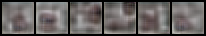

In [ ]:
sample = torch.randn(6, 3, 32, 32).to(device)

num_epochs = 70
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    average_train_loss = train(model, dataloader, criterion, optimizer)
    print(f"Average Train Loss: {average_train_loss:.4f}\n")
#denoise

model.eval()
timestep = torch.full((6,), 100, dtype=torch.long).to(device)

with torch.no_grad():
    denoised_sample = model(sample, timestep=timestep)

show_images(denoised_sample.sample)

###Q2.4 Conditional Equation (15 points)

In this part, you should express $\alpha_t$ in terms of the values of $\beta_i$, in the following equation:

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Take this into account that the conditional variance for the one step forward diffusion (the following equation) at time t is given by $\beta_t$.

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$

## solution:



To express $\alpha_t$ in $\beta_i$ terms of values, we need to consider the cumulative effect of the noise introduced at each timestep. The cumulative variance up to time $t$ can be recursively defined by considering the contribution of $\beta_i$ at each step. This recursive application affects $\alpha_t$ since $\alpha_t$ and the variance $1 - \alpha_t$ are directly influenced by the accumulation of noise over time.
The expression for $\alpha_t$ in terms of $\beta_i$ is: $\alpha_t = (1 - \beta_t)^t$. This formulation assumes a constant $\beta_t$ across all timesteps, which simplifies the relationship significantly. In a more general scenario, where $\beta_i$ varies with each timestep $i$ the expression for $\alpha_t$ would be the product of all $(\beta_i - 1)$ from $i = 1$ to $t$, representing the cumulative scaling effect of the process up to time $t$. This can be more accurately expressed as: $\alpha_t = ∏_{i=1}^{t}(1-\beta_i)$. This product captures the cumulative effect of the noise introduced at each step $i$ up to time $t$ which scales the initial state $z_{0}$ to get to $z_{t}$


